In [1]:
%%sh
#Dependencies
pip install tqdm
pip install pydotplus
pip install pydot

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import nltk
nltk.download('stopwords')  

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
%load_ext autoreload
%autoreload 2

# helper python file
import ml_pipeline as pipeline

Using TensorFlow backend.


In [4]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Input, LSTM, Bidirectional, Conv1D
from keras.layers import Dropout, Embedding
from keras.preprocessing import text, sequence
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from keras.models import Model

In [5]:
(train_df,test_df)=pipeline.read_input_data()
(seq_test,seq_train,word_index)=pipeline.tokenize_data(test_df,train_df)
y_train = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

  2%|▏         | 3374/153164 [00:00<00:04, 33711.58it/s]

num train:  159571
num test:  153164
pre-processing train data...


100%|██████████| 159571/159571 [00:04<00:00, 32207.96it/s]


tokenizing input data...
dictionary size:  348520


In [6]:
EMBEDDING = 'Glove-Twitter'
embedding_matrix=pipeline.prepare_embeddings(EMBEDDING,word_index)

1193514it [01:14, 16034.12it/s]


preparing embedding matrix...
number of null word embeddings: 1656


In [7]:
max_features=20000
max_seq_len=150

In [10]:
def init_BiLSTM_Conv_Model(embedding_matrix):
    # Build Model
    inp = Input(shape=(max_seq_len,))

    x = Embedding(max_features, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False)(inp)
    x = SpatialDropout1D(0.35)(x)

    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.15, recurrent_dropout=0.15))(x)
    x = Conv1D(64, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform')(x)

    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])

    out = Dense(6, activation='sigmoid')(x)

    model = Model(inp, out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [9]:
model=init_BiLSTM_Conv_Model(embedding_matrix)











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 150, 200)     4000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 150, 200)     0           embedding_1[0][0]                
______________________________________________________________________________________

In [11]:
from keras.utils import plot_model
plot_model(model,
           to_file='images/bilstm_conv_model.png',
           show_shapes=True,
           show_layer_names=True)

In [12]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "images/bilstm_conv_model.png")

In [13]:
# Prediction
batch_size = 128
epochs = 4

history = model.fit(seq_train, y_train, epochs = epochs, batch_size = 128, validation_split = 0.2,verbose=1)
#model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, verbose=1)



Train on 127656 samples, validate on 31915 samples
Epoch 1/4
127656/127656 [==============================] - 567s 4ms/step - loss: 0.0646 - acc: 0.9781 - val_loss: 0.0474 - val_acc: 0.9829
Epoch 2/4
127656/127656 [==============================] - 545s 4ms/step - loss: 0.0496 - acc: 0.9817 - val_loss: 0.0445 - val_acc: 0.9834
Epoch 3/4
127656/127656 [==============================] - 544s 4ms/step - loss: 0.0462 - acc: 0.9828 - val_loss: 0.0440 - val_acc: 0.9838
Epoch 4/4
127656/127656 [==============================] - 538s 4ms/step - loss: 0.0440 - acc: 0.9834 - val_loss: 0.0460 - val_acc: 0.9830


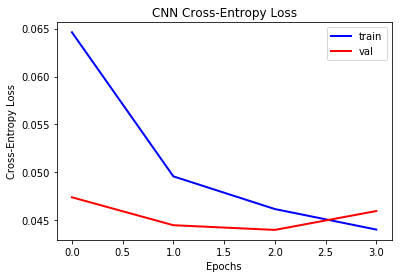

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN Cross-Entropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

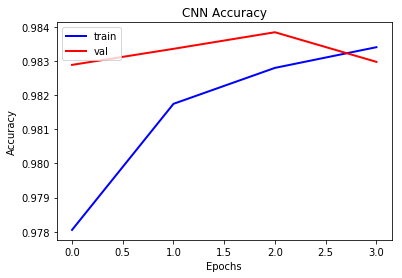

In [16]:
plt.figure()
plt.plot(history.history['acc'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [ ]:
y_test = model.predict(seq_test)
pipeline.create_submission_file(test_df,y_test,'bilstm_cnn_glove_twitter_submission.csv')